In [7]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

import time
import psutil
import threading
from memory_profiler import memory_usage


In [8]:
def apply_rf(X_train, y_train, best_params=None, random_state=42, n_jobs=-1, cv=5): 
    measurement_rf = {}
        
    # Default to empty dictionary if best_params is not provided
    best_params = best_params or {}

    rf_model = RandomForestClassifier(**best_params, random_state=random_state, n_jobs=n_jobs, verbose=1)
    
    # Function to monitor CPU usage during training
    cpu_usage = []
    stop_flag = threading.Event()

    def monitor_cpu():
        while not stop_flag.is_set():
            cpu_usage.append(psutil.cpu_percent(interval=0.1))

    # Function to train the model
    def train_model():
        rf_model.fit(X_train, y_train)

    try:
        # Start CPU monitoring in a separate thread
        cpu_thread = threading.Thread(target=monitor_cpu)
        cpu_thread.start()

        # Measure memory usage and training time
        start_time = time.time()
        train_memory_rf = max(memory_usage((train_model,)))  # Measure peak memory usage
        training_time = time.time() - start_time

        # Stop CPU monitoring
        stop_flag.set()
        cpu_thread.join()

        # Add measurements
        measurement_rf['Memory Usage (MB)'] = train_memory_rf
        measurement_rf['Training Time (s)'] = training_time
        measurement_rf['Peak CPU Usage (%)'] = max(cpu_usage)
        measurement_rf['Average CPU Usage (%)'] = sum(cpu_usage) / len(cpu_usage) if cpu_usage else 0

        # Perform cross-validation
        cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=cv, n_jobs=n_jobs)

        return cv_scores_rf, measurement_rf, rf_model

    except Exception as e:
        import traceback
        print("⛔ Full error traceback:")
        traceback.print_exc()  # Print detailed error traceback
        print(f"Error during Random Forest training: {e}")
        return None, None, None

In [ ]:
def eval_dataset_w_RF(df, target_column="Label"):
    X = df.drop(target_column, axis=1)
    y = df[target_column]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    params_rf = {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}

    # Fitting the model
    cv_scores_rf, measurement_rf, rf_model = apply_rf(X_train, y_train, best_params=params_rf)

    # Making predictions
    y_pred_rf = rf_model.predict(X_test)
    
    # Evaluating the model performance on the cross validation set vs accuracy on the test set
    cv_scores_mean_rf = np.mean(cv_scores_rf)
    print(f'Cross validation average score: {cv_scores_mean_rf:.4f} +/- standard deviation: {np.std(cv_scores_rf):.4f}')

    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    print(f'Accuracy on the test set: {accuracy_rf:.4f}')
    
    # Checking computational cost
    print("Resource measurements:", measurement_rf)
    print(classification_report(y_test, y_pred_rf))

In [10]:
# # List of CSV files
# csv_files = [
#     '02-14-2018.csv', '02-15-2018.csv', '02-16-2018.csv', 
#     '02-21-2018.csv', '02-22-2018.csv', '02-23-2018.csv', 
#     '02-28-2018.csv', '03-01-2018.csv', '03-02-2018.csv'
# ]

# large_csv = '02-20-2018.csv'
# # Initialize an empty DataFrame for the combined data
# df = pd.DataFrame()

# # Loop through each CSV file, read it, and append to the combined DataFrame
# for file in csv_files:
#     try:
#         # Read the current CSV file
#         print(f"Reading {file}...")
#         df = pd.read_csv(file)
        
#         # Append to the combined DataFrame
#         df = pd.concat([df, df], ignore_index=True)
        
#         print(f"Successfully added {file}, combined shape: {df.shape}")
#     except Exception as e:
#         print(f"Error processing {file}: {e}")

# # Save the combined DataFrame to a new CSV file without indexes
# print("Saving combined dataset...")
# df.to_csv('CIC_IDS_2018_COMBINED.csv', index=False)
# print("Combined dataset saved as 'CIC_IDS_2018_COMBINED.csv'")
# print(f"Total shape of combined dataset: {df.shape}")

In [11]:
# df = pd.read_csv('02-20-2018.csv', engine='python')
# df = pd.read_csv("CIC_IDS_2018_COMBINED.csv", engine='python')
# combined_df = pd.concat([combined_df, df], ignore_index=True)
# combined_df.to_csv('CIC_IDS_2018_COMBINED_FULL.csv', index=False)
# del df


In [12]:
df = pd.read_csv("CIC_IDS_2018_COMBINED_FULL.csv", engine='python')

In [13]:
df.shape

(16233002, 84)

In [14]:
df.columns = df.columns.str.rstrip()
df.columns = df.columns.str.strip()

In [15]:
df.columns

Index(['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
      

In [16]:
df["Label"].unique()[1:]

array(['FTP-BruteForce', 'SSH-Bruteforce', 'DoS attacks-GoldenEye',
       'DoS attacks-Slowloris', 'DoS attacks-SlowHTTPTest',
       'DoS attacks-Hulk', 'Label', 'DDOS attack-LOIC-UDP',
       'DDOS attack-HOIC', 'Brute Force -Web', 'Brute Force -XSS',
       'SQL Injection', 'Infilteration', 'Bot', 'DDoS attacks-LOIC-HTTP'],
      dtype=object)

Features with at least one NaN or Infinity value:
Flow Byts/s      59721
Flow ID        8284254
Src IP         8284254
Src Port       8284254
Dst IP         8284254
dtype: int64


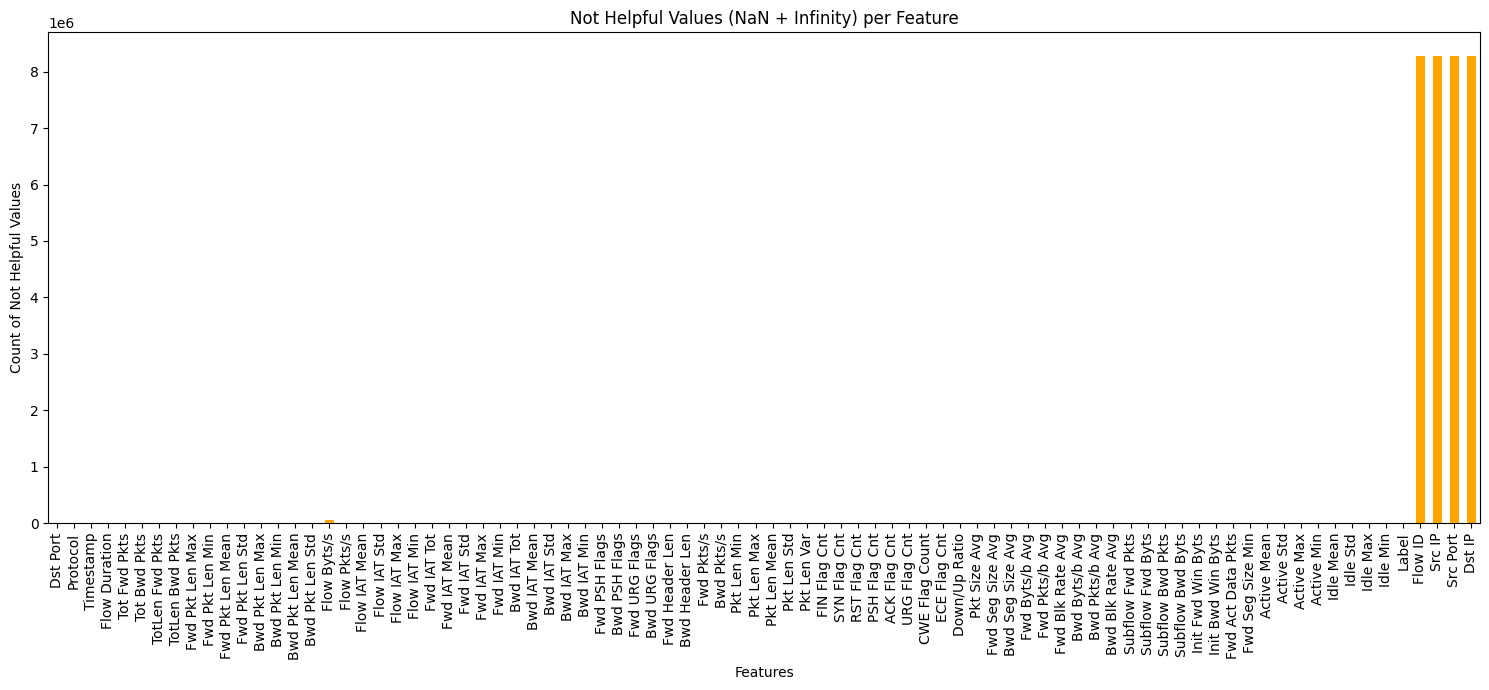

In [17]:
nan_counts = df.isna().sum()
def count_infs(col):
    if pd.api.types.is_numeric_dtype(col):
        return np.isinf(col).sum()
    else:
        return 0
inf_counts = df.apply(count_infs)
not_helpful_counts = nan_counts + inf_counts
features_with_issue = not_helpful_counts[not_helpful_counts > 0]
print("Features with at least one NaN or Infinity value:")
print(features_with_issue)
plt.figure(figsize=(15, 7))
not_helpful_counts.plot(kind='bar', color='orange')
plt.title("Not Helpful Values (NaN + Infinity) per Feature")
plt.xlabel("Features")
plt.ylabel("Count of Not Helpful Values")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [18]:
# Checking for infinite values
num_columns = df.select_dtypes(include = np.number).columns
has_infinite = np.isinf(df[num_columns]).sum()
print(has_infinite[has_infinite > 0])

Series([], dtype: int64)


In [19]:
# Treating infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [20]:
# Attack counts
attack_counts = df['Label'].value_counts().reset_index()
attack_counts.columns = ['Attack Type', 'Number of Occurrences']

# Duplicating the df and dropping rows with missing values
data_no_na = df.dropna()

# Counting the total number of occurrences of each attack after dropping
occurrences_nonull = data_no_na['Label'].value_counts().reset_index()
occurrences_nonull.columns = ['Attack Type', 'Occurrences w/o Null Rows']

# Merging the DataFrames
attack_counts = attack_counts.merge(occurrences_nonull, on='Attack Type', how='left')

# Calculating the difference
attack_counts['Abs Difference'] = attack_counts['Number of Occurrences'] - attack_counts['Occurrences w/o Null Rows']
attack_counts['Difference %'] = ((attack_counts['Abs Difference'] * 100) / attack_counts['Number of Occurrences']).round(2)

# Visualization
attack_counts

,Attack Type,Number of Occurrences,Occurrences w/o Null Rows,Abs Difference,Difference %
0,Benign,13484708,7335790.0,6148918.0,45.6
1,DDOS attack-HOIC,686012,NaN,NaN,NaN
2,DDoS attacks-LOIC-HTTP,576191,576191.0,0.0,0.0
3,DoS attacks-Hulk,461912,NaN,NaN,NaN
4,Bot,286191,NaN,NaN,NaN
5,FTP-BruteForce,193360,NaN,NaN,NaN
6,SSH-Bruteforce,187589,NaN,NaN,NaN
7,Infilteration,161934,NaN,NaN,NaN
8,DoS attacks-SlowHTTPTest,139890,NaN,NaN,NaN
9,DoS attacks-GoldenEye,41508,NaN,NaN,NaN


In [21]:
# Cleaning up
# del data_no_na

# Evaluating percentage of missing values per column
threshold = 10
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Filter columns with missing values over the threshold
high_missing_cols = missing_percentage[missing_percentage > threshold]

# Print columns with high missing percentages
if len(high_missing_cols) > 0:
    print(f'The following columns have over {threshold}% of missing values:')
    print(high_missing_cols)
else:
    print('There are no columns with missing values greater than the threshold')

The following columns have over 10% of missing values:
Flow ID     51.033407
Src IP      51.033407
Src Port    51.033407
Dst IP      51.033407
dtype: float64


In [22]:
row_missing_percentage = (df.isna().sum(axis=1) / df.shape[1]) * 100
print(row_missing_percentage.describe())

missing_rows = df.isna().any(axis=1).sum()
print(f'\nTotal rows with missing values: {missing_rows}')

count    1.623300e+07
mean     2.434542e+00
std      2.380431e+00
min      0.000000e+00
25%      0.000000e+00
50%      4.761905e+00
75%      4.761905e+00
max      5.952381e+00
dtype: float64

Total rows with missing values: 8321021


In [23]:
# Dropping missing values
df = df.dropna()
print(f'Dataset shape after row-wise removal: {df.shape}')

Dataset shape after row-wise removal: (7911981, 84)


In [24]:
nan_counts = df.isna().sum()
inf_counts = df.apply(count_infs)
print("Features with NaNs")
print(nan_counts[nan_counts>0])
print("Features with Infs")
print(inf_counts[inf_counts>0])

Features with NaNs
Series([], dtype: int64)
Features with Infs
Series([], dtype: int64)


In [ ]:
# Result of RF before any datacleaning
eval_dataset_w_RF(df)

In [ ]:
string_features = list(df.select_dtypes(include=['object']).columns)
string_features.remove('Label')
string_features

In [ ]:
le = preprocessing.LabelEncoder()
df[string_features] = df[string_features].apply(lambda col: le.fit_transform(col))
df['Label'].value_counts()

In [ ]:
col_names = {col: col.strip() for col in df.columns}
df.rename(columns = col_names, inplace = True)

In [ ]:
print(f"Original shape: {df.shape}")
df = df.drop_duplicates(keep='first')
print(f"Without duplicate rows shape: {df.shape}")

In [ ]:
identical_columns = {}
columns = df.columns
list_control = columns.copy().tolist()

for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            if df[col1].equals(df[col2]):
                if (col1 not in identical_columns) and (col1 in list_control):
                    identical_columns[col1] = [col2]
                    list_control.remove(col2)
                elif (col1 in identical_columns) and (col1 in list_control):
                    identical_columns[col1].append(col2)
                    list_control.remove(col2)

if identical_columns:
    print("Identical columns found:")
    for key, value in identical_columns.items():
        print(f"'{key}' is identical to {value}")
else: print("No identical columns found.")

In [ ]:
for key, value in identical_columns.items():
    df.drop(columns=value, inplace=True)

In [ ]:
df.columns

In [ ]:
df.shape

In [ ]:
# Check for numeric columns that contain only a single unique value, indicating no diversity in values.
# Such columns contribute no useful information to the analysis and may be candidates for removal.
only_unique_cols = []
for col in df.columns:
    if len(df[col].unique()) == 1:
        only_unique_cols.append(col)
        print(col)

print(f'\nThe number of columns with only one unique values is: {len(only_unique_cols)}')

In [ ]:
# Dropping the columns with only one unique value
df.drop(only_unique_cols, axis=1, inplace=True)
del only_unique_cols

In [ ]:
# Result of RF before any datacleaning
eval_dataset_w_RF(df)